In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.naive_bayes import GaussianNB as GMM

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,...,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000
mean,0.271778,0.277427,0.196409,0.172584,0.155856,0.147383,0.137123,0.137427,0.127727,0.125805,...,-0.000042,0.000060,-0.000030,0.000046,-0.000036,0.000034,-0.000015,0.000021,0.623402,24.497135
std,0.152690,0.154592,0.088349,0.075266,0.066213,0.060945,0.056277,0.057575,0.051265,0.050852,...,0.000670,0.000621,0.000643,0.000617,0.000649,0.000603,0.000628,0.000569,0.484586,14.519294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.017461,-0.005907,-0.005809,-0.009156,-0.016274,-0.005280,-0.003952,-0.006403,0.000000,0.000000
25%,0.146685,0.143912,0.133364,0.120063,0.111619,0.106004,0.100349,0.097655,0.094181,0.091991,...,-0.000126,-0.000040,-0.000111,-0.000045,-0.000105,-0.000051,-0.000093,-0.000049,0.000000,12.000000
50%,0.255615,0.270452,0.197800,0.172240,0.155154,0.147672,0.136195,0.137088,0.127714,0.125865,...,-0.000029,0.000025,-0.000024,0.000015,-0.000021,0.000007,-0.000014,0.000004,1.000000,24.000000
75%,0.372589,0.387784,0.252908,0.220791,0.197310,0.184662,0.170713,0.173707,0.158522,0.156500,...,0.000032,0.000121,0.000035,0.000100,0.000036,0.000087,0.000043,0.000082,1.000000,37.000000
max,0.782623,0.839244,0.561361,0.483876,0.458426,0.454676,0.490386,0.424678,0.377254,0.407372,...,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,1.000000,49.000000


In [13]:
from sklearn.preprocessing import normalize

train_X = df.drop(['l_target', 'h_target'], axis=1)
train_y = df['l_target']

# GMM
With GMMs we need to train one per class

In [26]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

def plot_calibration_curve(est, name, fig_index, X_train, y_train, X_test, y_test):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# All Data

In [28]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [29]:
test_X = all_df.drop(['l_target', 'h_target'], axis=1)
test_y = all_df['l_target']

In [41]:
plot_calibration_curve(GMM(n_components=50), "Naive Bayes", 1, train_X, train_y, test_X, test_y)

TypeError: __init__() got an unexpected keyword argument 'n_components'

In [32]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = GMM(n_components=50)

eclf = VotingClassifier(estimators=[('rf', clf1),('gnb', clf2)], voting='soft')

clf1 = clf1.fit(train_X, train_y)
clf2 = clf2.fit(train_X, train_y)
eclf = eclf.fit(train_X, train_y)

Logistic:
	Brier: 0.187
	Precision: 0.721
	Recall: 0.862
	F1: 0.785

Ensemble:
	Brier: 0.226
	Precision: 0.880
	Recall: 0.374
	F1: 0.524

Ensemble + Isotonic:
	Brier: 0.157
	Precision: 0.807
	Recall: 0.851
	F1: 0.828

Ensemble + Sigmoid:
	Brier: 0.175
	Precision: 0.804
	Recall: 0.845
	F1: 0.824



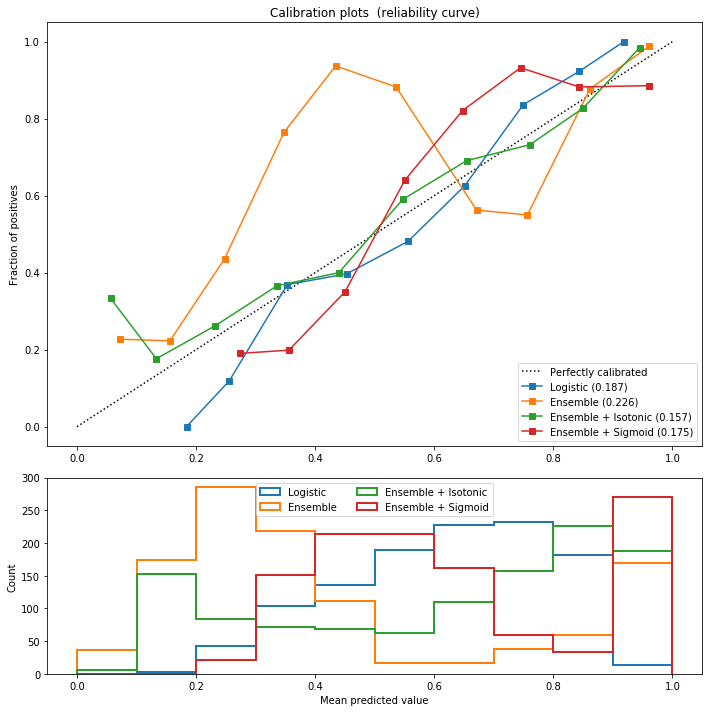

In [33]:
plot_calibration_curve(eclf, "Ensemble", 1, train_X, train_y, test_X, test_y)

0.5763765541740675
Confusion matrix, without normalization
[[386  36]
 [441 263]]


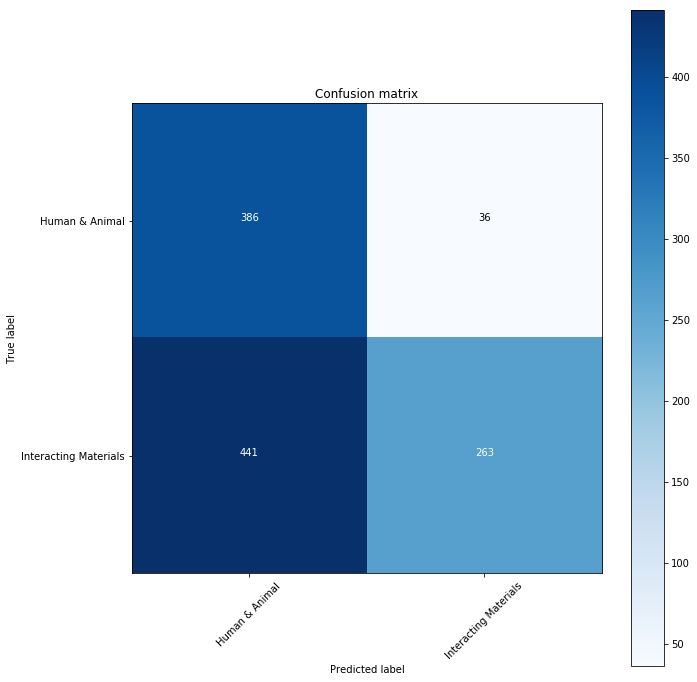

In [35]:
pred = eclf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

0.7744227353463587
Confusion matrix, without normalization
[[287 135]
 [119 585]]


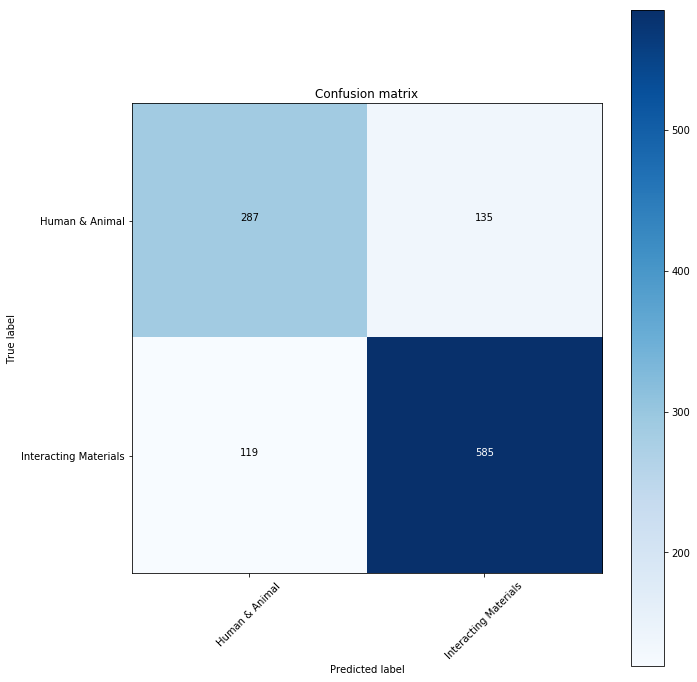

In [36]:
pred = clf1.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

0.5612788632326821
Confusion matrix, without normalization
[[387  35]
 [459 245]]


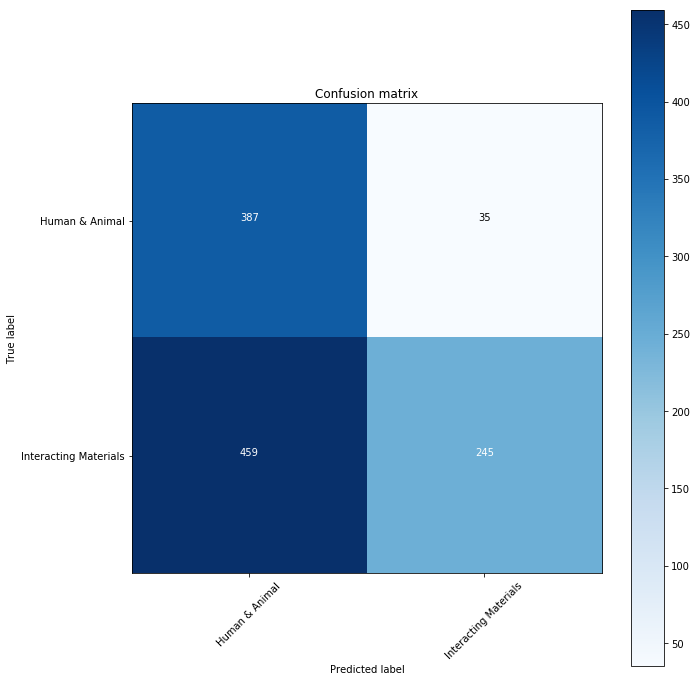

In [37]:
pred = clf2.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [39]:
sigmoid = CalibratedClassifierCV(eclf, cv=2, method='sigmoid')
sigmoid.fit(train_X, train_y)

CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_sam..., var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None),
            cv=2, method='sigmoid')

0.7744227353463587
Confusion matrix, without normalization
[[277 145]
 [109 595]]


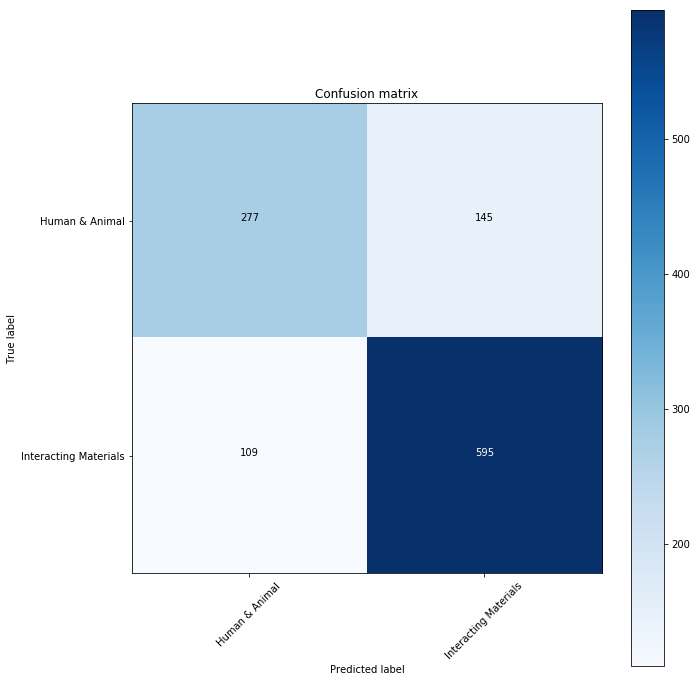

In [40]:
pred = sigmoid.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()